In [1]:
# Initial Setup & Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import RobustScaler 
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import lag_plot
import matplotlib.ticker as mticker
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [3]:
# Load the Dataset (Adjust file path if necessary)
df = pd.read_csv('./data_with_indicators/stock_prices_2minute_with_indicators.csv', parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Ticker,EMA12,EMA26,MACD,Signal,...,STOCHS_Sell,+DI,-DI,ADX,ADX_Buy,ADX_Sell,Aroon_Up,Aroon_Down,Aroon_Buy,Aroon_Sell
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-31 09:00:00,252.14,252.14,252.01,252.01,1123.0,AAPL,252.010000,252.010000,0.000000,0.000000,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
2024-12-31 09:00:00,221.03,221.03,221.00,221.00,588.0,AMZN,262.147404,266.798218,-4.650814,-1.558348,...,False,61.212857,-61.212857,133.566327,True,False,0.0,96.0,False,True
2024-12-31 09:00:00,136.99,137.16,136.97,137.11,17972.0,NVDA,160.585968,162.723328,-2.137360,-0.419032,...,False,5.910714,-5.910714,8.011837,False,True,88.0,96.0,False,True
2024-12-31 09:00:00,414.01,416.38,414.01,414.75,29498.0,TSLA,158.742332,134.607084,24.135247,4.797317,...,False,27.642857,-27.642857,21.598163,False,True,96.0,8.0,True,False
2024-12-31 09:02:00,137.18,137.40,137.11,137.27,15133.0,NVDA,156.998896,160.837896,-3.839000,-1.103026,...,False,6.696429,-6.696429,8.366020,False,True,84.0,92.0,False,True


In [6]:
# Add return target early for volatility plot
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure Datetime is a column
df.reset_index(inplace=True) 

# Load both sentiment files
sent1 = pd.read_csv('aggregated_daily_sentiment_1.csv')
sent2 = pd.read_csv('aggregated_daily_sentiment_2.csv')

# Combine them in order: part 1 comes before part 2
sentiment = pd.concat([sent1, sent2], ignore_index=True)

# Rename and parse dates
sentiment.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

# Reshape to long format: Date | Ticker | Sentiment
sentiment = sentiment.melt(id_vars='Date', var_name='Ticker', value_name='Sentiment')
sentiment['Date'] = sentiment['Date'].dt.normalize()
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)

# Prepare stock data date column
df['Date'] = df['Datetime'].dt.normalize()
df['Date'] = df['Date'].dt.tz_localize(None)

# Merge daily sentiment into intraday stock data
df = pd.merge(df, sentiment, how='left', on=['Date', 'Ticker'])
df.drop(columns='Date', inplace=True)

# Fill any missing sentiment values with neutral (0)
df['Sentiment'] = df['Sentiment'].fillna(0)

In [8]:
stocks = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA", "AMZN", "META"] 

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

def build_lstm_model(input_shape, dropout_rate=0.3, learning_rate=0.001):

    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate), 

        LSTM(32),
        Dropout(dropout_rate),

        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='tanh')
    ])
    
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae']
    )
    
    return model


def train_and_evaluate(df, feature_cols, ticker):
    """
    Trains and evaluates the model for a specific stock ticker using hyperparameter optimization.

    Parameters:
    df (DataFrame): The dataset containing stock data
    feature_cols (list): List of feature column names
    ticker (str): The ticker symbol for the stock being evaluated

    Returns:
    trades (DataFrame): DataFrame with trading strategy results
    """
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values('Datetime').reset_index(drop=True)

    # Split data based on date
    train_data = df_ticker[df_ticker['Datetime'] < '2025-03-01']
    test_data = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

    # Prepare sequences
    X_train, y_train, _, _, return_scaler = prepare_sequences(train_data, feature_cols)
    X_test, y_test, dates_test, close_prices_test, _ = prepare_sequences(test_data, feature_cols)

    global num_features
    num_features = X_train.shape[2]

    # Define the KerasRegressor with the build function
    keras_model = KerasRegressor(model=build_lstm_model, model__input_shape=(X_train.shape[1], num_features), epochs=30, verbose=0)

    # Randomized Search Parameter Grid
    param_dist = {
        "model__dropout_rate": [0.2, 0.3],  # Randomly choose from 0.2 to 0.5
        "model__learning_rate": [0.001, 0.0005, 0.0003],  # Trial different learning rates
        "batch_size": [16, 32, 64]  # Different batch sizes
    }

    # Callbacks for early stopping and learning rate reduction
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # RandomizedSearchCV for hyperparameter optimization
    search = RandomizedSearchCV(
        estimator=keras_model,
        param_distributions=param_dist,
        n_iter=3,  # Number of random combinations to try
        cv=2,  # 2-fold cross-validation
        verbose=1,
        n_jobs=1
    )

    #search.fit(X_train, y_train, callbacks=callbacks)
    #print(f"Best params for {ticker}:", search.best_params_)

    # Get the best model from the search
    best_model = search.best_estimator_.model_

    # Predictions
    y_pred_scaled = best_model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_actual = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Trading logic (no trading fees)
    positions = np.where(y_pred.flatten() > 0, 'LONG', 'SHORT')
    strategy_returns = np.zeros_like(y_test_actual.flatten())

    for i in range(len(y_test_actual)):
        curr_position = positions[i]
        if curr_position == 'LONG':
            ret = y_test_actual[i]
        elif curr_position == 'SHORT':
            ret = -y_test_actual[i]
        else:
            ret = 0
        strategy_returns[i] = ret

    cumulative_return = np.cumprod(1 + strategy_returns)

    trades = pd.DataFrame({
        'Date': dates_test,
        'Close_Price': close_prices_test,
        'Actual_Return': y_test_actual.flatten(),
        'Predicted_Return': y_pred.flatten(),
        'Position': positions,
        'Strategy_Return': strategy_returns,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })

    return trades

feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell',
                'Sentiment']

# Train models and compile trades
all_trades = []
for ticker in stocks:
    print(f"Training model for {ticker}...")
    trades = train_and_evaluate(df, feature_cols, ticker)
    all_trades.append(trades)

all_trades_df = pd.concat(all_trades, ignore_index=True) 

Training model for AAPL...


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [19]:
# Add return target for modeling and volatility plots
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure correct datetime and indexing
df = df.sort_values(['Ticker', 'Datetime']).reset_index(drop=True)

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Improved LSTM model structure
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='tanh')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# Train and evaluate model
def train_and_evaluate(df, feature_cols, ticker):
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values('Datetime').reset_index(drop=True)

    # Split by date
    train_data = df_ticker[df_ticker['Datetime'] < '2025-03-01']
    test_data = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

    # Prepare sequences
    X_train, y_train, _, _, return_scaler = prepare_sequences(train_data, feature_cols)
    X_test, y_test, dates_test, close_prices_test, _ = prepare_sequences(test_data, feature_cols)

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    # Make predictions and inverse scale
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    # --- Apply trading strategy logic with fees ---
    positions = np.where(y_pred.flatten() > 0, 'LONG', 'SHORT')
    strategy_returns = np.zeros_like(y_test_actual.flatten())

    prev_position = None
    for i in range(len(y_test_actual)):
        curr_position = positions[i]

        # Base return from position
        if curr_position == 'LONG':
            ret = y_test_actual[i]
        elif curr_position == 'SHORT':
            ret = -y_test_actual[i]
        else:
            ret = 0

        strategy_returns[i] = ret
        prev_position = curr_position

    # Compute cumulative return
    cumulative_return = np.cumprod(1 + strategy_returns)

    # Compile into a DataFrame
    trades = pd.DataFrame({
        'Date': dates_test,
        'Close_Price': close_prices_test,
        'Actual_Return': y_test_actual.flatten(),
        'Predicted_Return': y_pred.flatten(),
        'Position': positions,
        'Strategy_Return': strategy_returns,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })

    return trades


feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell',
                'Sentiment']

# Train models and compile trades
all_trades = []
for ticker in stocks:
    print(f"Training model for {ticker}...")
    trades = train_and_evaluate(df, feature_cols, ticker)
    all_trades.append(trades)

all_trades_df = pd.concat(all_trades, ignore_index=True)


Training model for AAPL...
Epoch 1/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - loss: 1.9532 - mae: 0.8736 - val_loss: 1.4744 - val_mae: 0.7973 - learning_rate: 5.0000e-04
Epoch 2/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 1.8617 - mae: 0.8186 - val_loss: 1.4616 - val_mae: 0.7880 - learning_rate: 5.0000e-04
Epoch 3/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 1.8336 - mae: 0.8045 - val_loss: 1.4679 - val_mae: 0.7925 - learning_rate: 5.0000e-04
Epoch 4/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - loss: 1.8413 - mae: 0.8054 - val_loss: 1.4654 - val_mae: 0.7904 - learning_rate: 5.0000e-04
Epoch 5/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - loss: 1.8339 - mae: 0.8032 - val_loss: 1.4630 - val_mae: 0.7884 - learning_rate: 5.0000e-04
Epoch 6/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 1.8319 - mae: 0.7995 - val_loss: 1.4552 - val_mae: 0.7844 - learning_rate: 5.0000e-04
Epoch 7/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 1.8289 - mae: 0.7992 - 

In [39]:
# Sensitivity analysis function
def run_sensitivity_analysis(df):
    """
    Perform sensitivity analysis by adjusting the predicted returns and evaluating final cumulative return.
    """
    sensitivity_factors = [0.5, 0.8, 0.9, 1.0, 1.1, 1.2,  1.5]
    results = []

    for factor in sensitivity_factors:
        df_temp = df.copy()
        df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return'] * factor

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((factor, cumulative_return))

    df_sensitivity = pd.DataFrame(results, columns=["Adjustment_Factor", "Final_Cumulative_Return"])
    return df_sensitivity

# Stress testing function
def run_stress_testing(df):
    """
    Perform stress tests by simulating various market shock scenarios.
    """
    scenarios = {
        'Crash': df['Actual_Return'] - 0.00005,  
        'Volatility_Spike': df['Actual_Return'] + np.random.normal(0, 0.00002, size=len(df)),
        'Prediction_Inverted': -df['Predicted_Return'],
        'Zero_Prediction': np.zeros_like(df['Predicted_Return']), 
        'Normal': df['Actual_Return']
    }

    results = []
    for scenario_name, shock in scenarios.items():
        df_temp = df.copy()

        if 'Prediction' in scenario_name:
            df_temp['Adj_Predicted_Return'] = shock
        else:
            df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return']
            df_temp['Actual_Return'] = shock

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((scenario_name, cumulative_return))

    df_stress = pd.DataFrame(results, columns=["Scenario", "Final_Cumulative_Return"])
    return df_stress 




In [36]:
run_sensitivity_analysis(all_trades_df) 

,Adjustment_Factor,Final_Cumulative_Return
0,0.5,1.455478
1,0.8,1.455478
2,0.9,1.455478
3,1.0,1.455478
4,1.1,1.455478
5,1.2,1.455478
6,1.5,1.455478


In [40]:
run_stress_testing(all_trades_df)

,Scenario,Final_Cumulative_Return
0,Crash,2.662331
1,Volatility_Spike,1.452131
2,Prediction_Inverted,0.644688
3,Zero_Prediction,1.349915
4,Normal,1.455478


In [29]:
abs(all_trades_df['Strategy_Return']).mean()

0.0006884795765209311

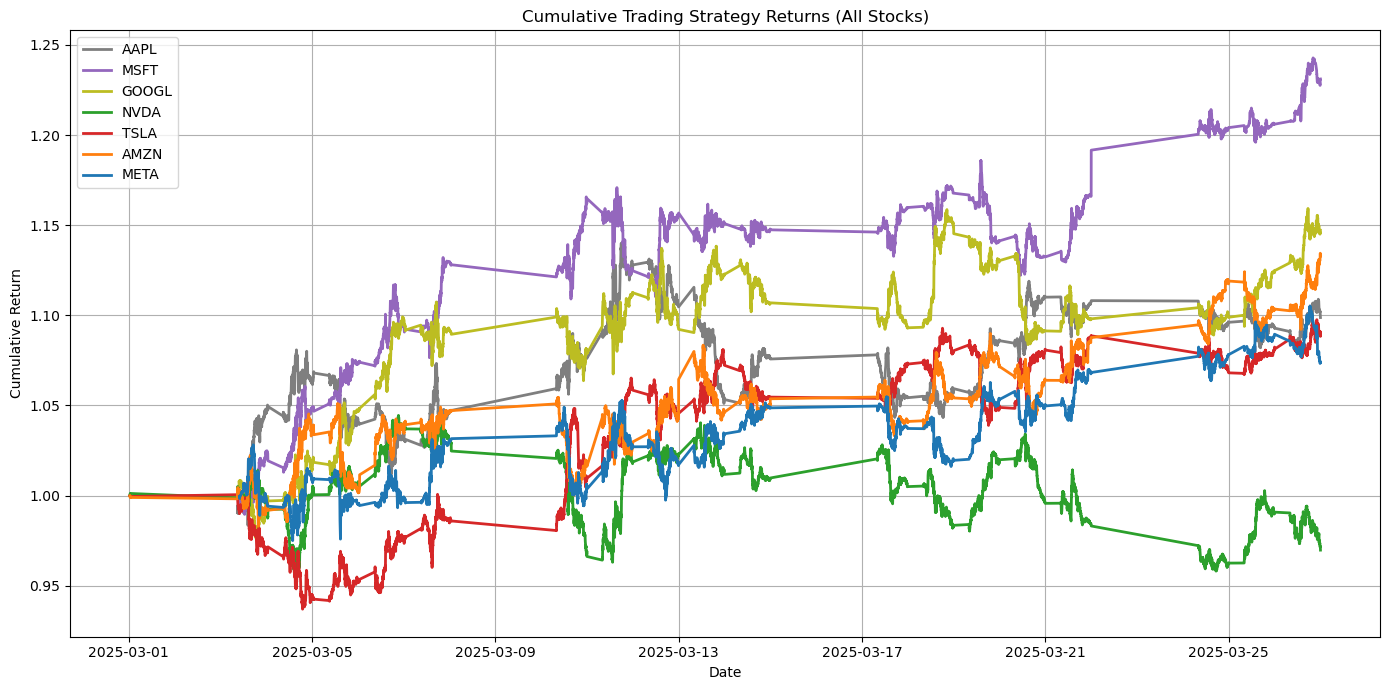

In [14]:
colors = ['tab:gray', 'tab:purple', 'tab:olive','tab:green', 'tab:red', 'tab:orange', 'tab:blue']

# Add rolling metrics
all_trades_df['Rolling_Risk'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_df['Rolling_Average'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())

# Improved Trading Strategy Plot with consistent x-axis and grid
def plot_trading_strategy(all_trades_df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        ticker_data = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(pd.to_datetime(ticker_data['Date']), ticker_data['Cumulative_Return'], label=ticker, color=color, linewidth=2)
    plt.title('Cumulative Trading Strategy Returns (All Stocks)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_trading_strategy(all_trades_df)

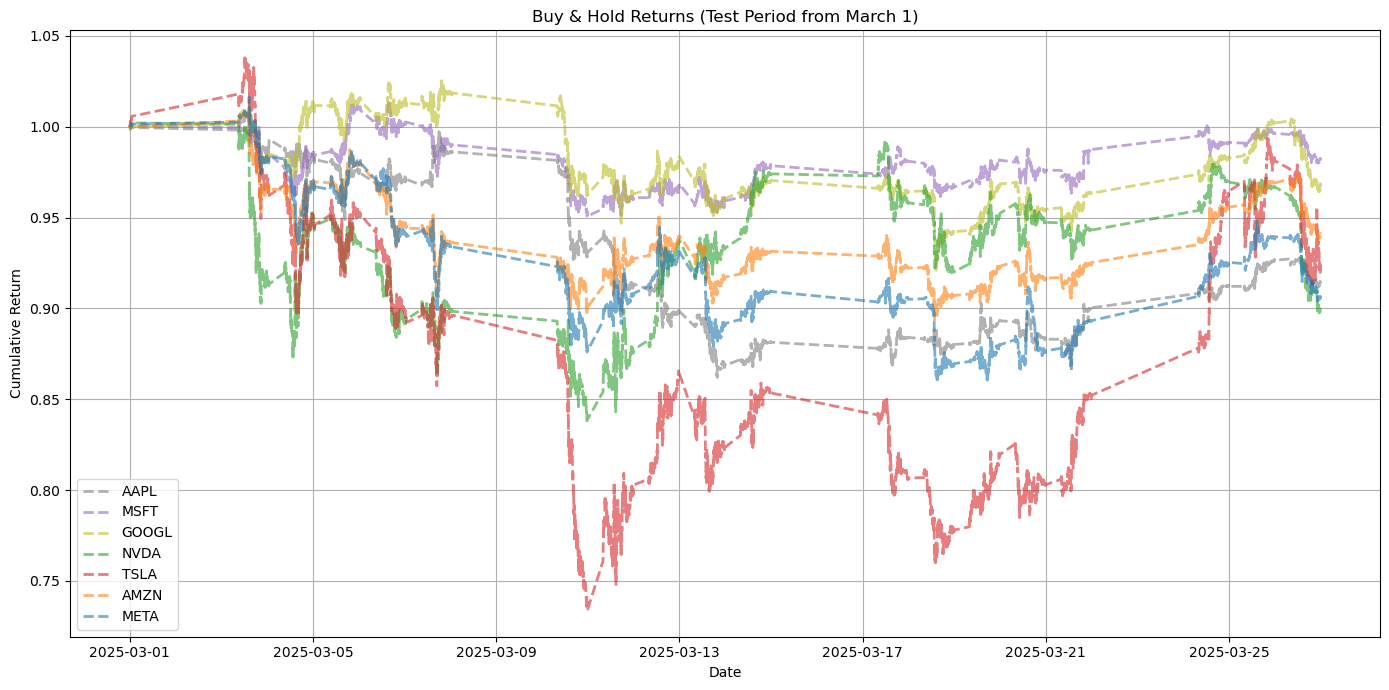

In [15]:
# Improved Buy & Hold Plot with consistent datetime parsing
import matplotlib.colors as mcolors

def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty:
            continue

        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]
        # Use darker version of the color
        darker_color = mcolors.to_rgba(color, alpha=0.6)
        plt.plot(df_test['Datetime'], buy_hold_returns, label=f'{ticker}', color=darker_color, linestyle='--', linewidth=2)

    plt.title('Buy & Hold Returns (Test Period from March 1)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_buy_and_hold_test_period(df)

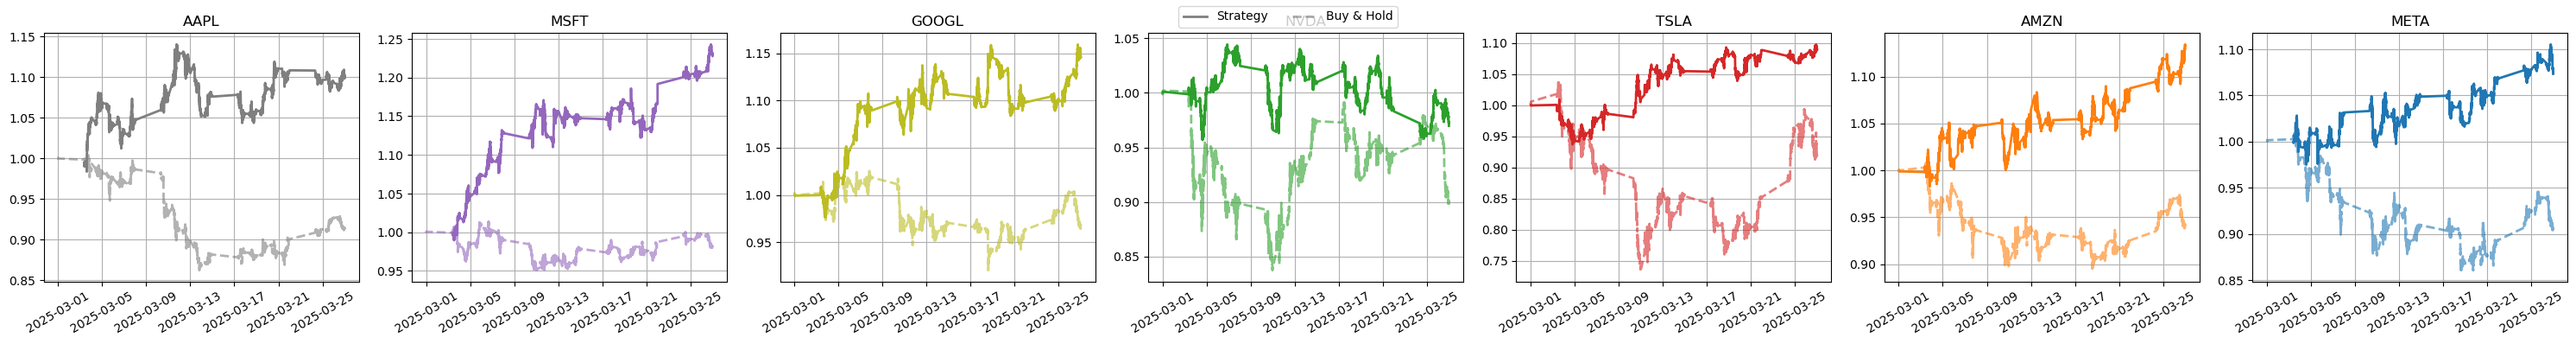

In [16]:
def plot_trading_vs_buy_hold(df, all_trades_df):
    fig, axes = plt.subplots(1, 7, figsize=(30, 4))
    for ax, ticker, color in zip(axes, stocks, colors):
        trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty or trades.empty:
            continue

        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]
        darker_color = mcolors.to_rgba(color, alpha=0.6)

        ax.plot(pd.to_datetime(trades['Date']), trades['Cumulative_Return'], color=color, label='Strategy', linewidth=2)
        ax.plot(df_test['Datetime'], buy_hold_returns, color=darker_color, linestyle='--', label='Buy & Hold', linewidth=2)

        ax.set_title(f'{ticker}')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=30)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=True, fontsize=10)
    plt.tight_layout()
    plt.show()


plot_trading_vs_buy_hold(df, all_trades_df)

In [17]:
# Compare final returns
def calculate_strategy_returns(df, all_trades_df):
    results = []
    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty:
            continue

        buy_and_hold_return = (df_test['Close'].iloc[-1] / df_test['Close'].iloc[0]) - 1

        df_trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] - 1 if not df_trades.empty else None

        results.append({
            "Ticker": ticker,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
print(strategy_returns_df)

  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0   AAPL                  -8.46                         9.88
1   AMZN                  -5.83                        13.28
2  GOOGL                  -3.08                        14.72
3   META                  -9.37                         7.38
4   MSFT                  -1.82                        23.11
5   NVDA                 -10.04                        -3.03
6   TSLA                  -8.31                         9.03


In [ ]:
all_trades_df.head(5)